# Introduction

**Author: M. Ravasi, KAUST**

Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

The aim of this tutorial is to:

- Introduce you to the concept of *linear operators* and their usage in the solution of *inverse problems*;
- Show how PyLops can be used to set-up non-trivial linear operators and solve inverse problems in Python; 
- Walk you through a set of use cases where PyLops has been leveraged to solve real scientific problems and discuss future directions of development.

## Useful links

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2021
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Theory in a nutshell

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

At the core of PyLops lies the concept of **linear operators**. A linear operator is generally a mapping or function that acts linearly on elements of a space to produce elements of another space. More specifically we say that $\mathbf{A}:\mathbb{F}^m \to \mathbb{F}^n$ is a linear operator that maps a vector of size $m$ in the *model space* to a vector of size $n$ in the *data space*:

<img src="figs/forward.png" width="300">

We will refer to this as **forward model (or operation)**. 

Conversely the application of its adjoint to a data vector is referred to as **adjoint modelling (or operation)**:

<img src="figs/adjoint.png" width="300">

In its simplest form, a linear operator can be seen as a **matrix** of size $n \times m$ (and the adjoint is simply its transpose and complex conjugate). However in a more general sense we can think of a linear operator as any pair of software code that mimics the effect a matrix on a model vector as well as that of its adjoint to a data vector.

Solving an inverse problems accounts to removing the effect of the operator/matrix $\mathbf{A}$ from the data $\mathbf{y}$ to retrieve the model $\mathbf{x}$ (or an approximation of it).

$$\hat{\mathbf{x}} = \mathbf{A}^{-1} \mathbf{y}$$

In practice, the inverse of $\mathbf{A}$ is generally not explicitely required. A solution can be obtained using either direct methods, matrix decompositions (eg SVD) or iterative solvers. Luckily, many iterative methods (e.g. cg, lsqr) do not need to know the individual entries of a matrix to solve a linear system. Such solvers only require the computation of forward and adjoint matrix-vector products - exactly what a linear operator does!

**So what?**
We have learned that to solve an inverse problem, we do not need to express the modelling operator in terms of its dense (or sparse) matrix. All we need to know is how to perform the forward and adjoint operations - ideally as fast as possible and using the least amount of memory. 

Our first task will be to understand how we can effectively write a linear operator on pen and paper and translate it into computer code. We will consider 2 examples:

- Element-wise multiplication (also known as Hadamard product)
- First Derivative

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pympler scooby

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import pympler
import scooby

from scipy.linalg import lstsq
from scipy.signal import filtfilt
from pylops import LinearOperator
from pylops.utils import dottest
from pylops.utils.wavelets import ricker

## Element-wise multiplication

We start by creating a barebore linear operator that performs a simple element-wise multiplication between two vectors (the so-called Hadamart product):

$$ y_i = d_i x_i  \quad \forall i=0,1,...,n-1 $$

If we think about the forward problem the way we wrote it before, we can see that this operator can be equivalently expressed as a dot-product between a square matrix $\mathbf{D}$ that has the $d_i$ elements along its main diagonal and a vector $\mathbf{x}$:

<img src="figs/diagonal.png" width="600">

Because of this, the related linear operator is called *Diagonal* operator in PyLops.

We are ready to implement this operator in 2 different ways:

- directly as a diagonal matrix; 
- as a linear operator that performs directly element-wise multiplication.

### Dense matrix definition

In [3]:
n = 10
diag = np.arange(n)

D = np.diag(diag)
print('D:\n', D)

D:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


We can now apply the forward by simply using `np.dot`

In [4]:
x = np.ones(n)
y = np.dot(D, x) # or D.dot(x) or D @ x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


As we have access to all the entries of the matrix, it is very easy to write the adjoint

In [5]:
xadj = np.dot(np.conj(D.T), y)
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


*Note:* since the elements of our matrix are real numbers, we can avoid applying the complex conjugation here.

Everything seems very easy so far. This approach does however carry some problems:
    
- we are storing $N^2$ numbers, even though we know that our matrix has only elements along its diagonal.
- we are applying a dot product which requires $N^2$ multiplications and summations (most of them with zeros)

Of course in this case we could use a sparse matrix, which allows to store only non-zero elements (and their index) and provides a faster way to perform the dot product.

### Linear operator definition

Let's take a leap of faith, and see if we can avoid thinking about the matrix altogether and write just an equivalent (ideally faster) piece of code that mimics this operation.

To write its equivalent linear operator, we define a class with an init method, and 2 other methods:
    
- _matvec: we write the forward operation here
- _rmatvec: we write the adjoint operation here
    
We see that we are also subclassing a PyLops LinearOperator. For the moment let's not get into the details of what that entails and simply focus on writing the content of these three methods.

In [6]:
class Diagonal(LinearOperator):
    """Short version of a Diagonal operator. See
    https://github.com/equinor/pylops/blob/master/pylops/basicoperators/Diagonal.py
    for a more detailed implementation
    """
    def __init__(self, diag, dtype='float64'):
        self.diag = diag
        self.shape = (len(self.diag), len(self.diag))
        self.dtype = np.dtype(dtype)

    def _matvec(self, x):
        y = self.diag * x
        return y

    def _rmatvec(self, x):
        y = np.conj(self.diag) * x
        return y

Now we create the operator

In [7]:
Dop = Diagonal(diag)
print('Dop: ', Dop)

Dop:  <10x10 Diagonal with dtype=float64>


### Linear operator application

Forward

In [8]:
y = Dop * x # Dop @ x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Adjoint

In [9]:
xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


As expected we obtain the same results!

Let's try making a much bigger vector $\mathbf{x}$ and time the forward and adjoint for the two approaches

In [10]:
def Diagonal_timing():
    """Timing of Diagonal operator
    """
    n = 10000
    diag = np.arange(n)
    x = np.ones(n)

    # dense
    D = np.diag(diag)

    from scipy import sparse
    Ds = sparse.diags(diag, 0)

    # lop
    Dop = Diagonal(diag)

    # uncomment these
    %timeit -n3 -r3 np.dot(D, x)
    %timeit -n3 -r3 Ds.dot(x)
    %timeit -n3 -r3 Dop._matvec(x)

In [11]:
Diagonal_timing()

467 ms ± 68.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 14.02 times longer than the fastest. This could mean that an intermediate result is being cached.
78 µs ± 86.9 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 10.97 times longer than the fastest. This could mean that an intermediate result is being cached.
67.6 µs ± 52.7 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Linear operator testing

One of the most important aspect of writing a Linear operator is to be able to verify that the code implemented in forward mode and the code implemented in adjoint mode are effectively adjoint to each other. 

If this is not the case, we will struggle to invert our linear operator - some iterative solvers will diverge and other show very slow convergence.

This is instead the case if the so-called *dot-test* is passed within a certain treshold:

$$
(\mathbf{A}*\mathbf{u})^H*\mathbf{v} = \mathbf{u}^H*(\mathbf{A}^H*\mathbf{v})
$$

where $\mathbf{u}$ and $\mathbf{v}$ are two random vectors.

Let's use `pylops.utils.dottest`

In [12]:
dottest(Dop, n, n, verb=True);

Dot test passed, v^T(Opu)=-3.667123 - u^T(Op^Tv)=-3.667123


## First Derivative

Let's consider now something less trivial. 

<img src="figs/firstder.png" width="600">

We use a first-order centered first derivative stencil:

$$ y_i = \frac{x_{i+1} - x_{i-1}}{2 \Delta}  \quad \forall i=1,2,...,N $$

where $\Delta$ is the sampling step of the input signal. Note that we will deal differently with the edges, using a forward/backward derivative.

<img src="figs/firstder1.png" width="600">

### Dense matrix definition

In [13]:
nx = 11

D = np.diag(0.5*np.ones(nx-1), k=1) - np.diag(0.5*np.ones(nx-1), k=-1) 
D[0, 0] = D[-1, -2] = -1
D[0, 1] = D[-1, -1] = 1
print('D:\n', D)

D:
 [[-1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   1. ]]


### Linear operator definition

Now that you understand, you can use PyLops implementation of this operator (see https://pylops.readthedocs.io/en/latest/api/generated/pylops.FirstDerivative.html for details)

In [14]:
Dop = pylops.FirstDerivative(nx, edge=True)
print('Dop: ', Dop)

Dop:  <11x11 FirstDerivative with dtype=float64>


In [15]:
dottest(Dop, nx, nx, verb=True);

Dot test passed, v^T(Opu)=-4.770158 - u^T(Op^Tv)=-4.770158


### Linear operator application

In [16]:
x = np.arange(nx) - (nx-1)/2
print('x: ', x)

x:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Forward

In [17]:
y = np.dot(D, x)
print('y: ', y)

y = Dop * x
print('y: ', y)

y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Adjoint

In [18]:
xadj = np.dot(D.T, y)
print('xadj: ', xadj)

xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]
xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]


Let's try now to compare the memory footprint of the matrix $\mathbf{D}$ compared to its equivalent linear operator. Hint: install ``pympler`` and use ``pympler.asizeof``

In [19]:
def FirstDerivative_memory():
    """Memory footprint of Diagonal operator
    """
    from pympler import asizeof
    from scipy.sparse import diags
    nn = (10 ** np.arange(2, 4, 0.5)).astype(np.int)

    mem_D = []
    mem_Ds = []
    mem_Dop = []
    for n in nn:
        D = np.diag(0.5 * np.ones(n - 1), k=1) - np.diag(0.5 * np.ones(n - 1),
                                                         -1)
        D[0, 0] = D[-1, -2] = -1
        D[0, 1] = D[-1, -1] = 1
        Ds = diags((0.5 * np.ones(n - 1), -0.5 * np.ones(n - 1)),
                   offsets=(1, -1))
        Dop = pylops.FirstDerivative(n, edge=True)
        mem_D.append(asizeof.asizeof(D))
        mem_Ds.append(asizeof.asizeof(Ds))
        mem_Dop.append(asizeof.asizeof(Dop))

    plt.figure(figsize=(12, 3))
    plt.semilogy(nn, mem_D, '.-k', label='D')
    plt.semilogy(nn, mem_Ds, '.-b', label='Ds')
    plt.semilogy(nn, mem_Dop, '.-r', label='Dop')
    plt.legend()
    plt.title('Memory comparison')

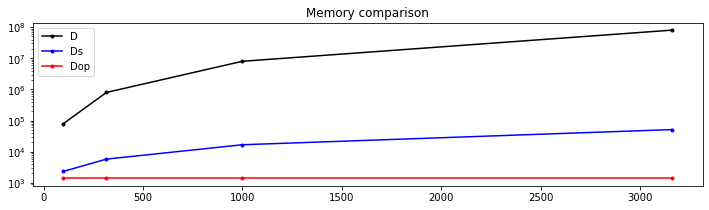

In [20]:
FirstDerivative_memory()

Finally, let's try to move on step further and try to solve the inverse problem. 

For the dense matrix, we will use `scipy.linalg.lstsq`. For operator PyLops this can be very easily done by using the '/' which will call `scipy.sparse.linalg.lsqr` solver (you can also use this solver directly if you want to fine tune some of its input parameters

In [21]:
xinv = lstsq(D, y)[0]
print('xinv: ', xinv)

xinv = Dop / y
print('xinv: ', xinv)

xinv:  [-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00  6.96836792e-16  1.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00]
xinv:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In both cases we have retrieved the correct solution!

## Chaining operators

Up until now, we have discussed how brand new operators can be created in few systematic steps. This sounds cool, but it may look like we would need to do this every time we need to solve a new problem.

This is where **PyLops** comes in. Alongside providing users with an extensive collection of operators, the library allows such operators to be combined via basic algebraic operations (eg summed, subtracted, multiplied) or chained together (vertical and horizontal stacking, block and block diagonal).

We will see more of this in the following. For now let's imagine to have a modelling operator that is a smooth first-order derivative. To do so we can chain the ``FirstDerivative`` operator ($\mathbf{D}$) that we have just created with a smoothing operator ($\mathbf{S}$)(https://pylops.readthedocs.io/en/latest/api/generated/pylops.Smoothing1D.html#pylops.Smoothing1D) and write the following problem:

$$\mathbf{y} = \mathbf{S} \mathbf{D} \mathbf{x}$$

<img src="figs/smoothder.png" width="800">

Let's create it first and attempt to invert it afterwards.

<51x51 LinearOperator with dtype=float64>


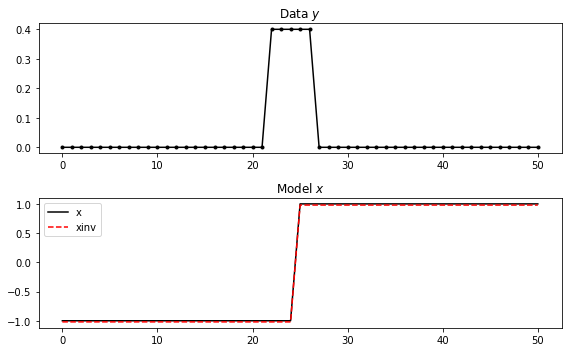

In [22]:
nx = 51
x = np.ones(nx)
x[:nx//2] = -1

Dop = pylops.FirstDerivative(nx, edge=True, kind='forward')
Sop = pylops.Smoothing1D(5, nx)

# Chain the two operators
Op = Sop * Dop
print(Op)

# Create data
y = Op * x

# Invert
xinv = Op / y
xinv = pylops.optimization.leastsquares.NormalEquationsInversion(Op, [pylops.Identity(nx)], y, epsRs=[1e-3,])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
ax1.plot(y, '.-k')
ax1.set_title(r"Data $y$")
ax2.plot(x, 'k', label='x')
ax2.plot(xinv, '--r', label='xinv')
ax2.legend()
ax2.set_title(r"Model $x$")
plt.tight_layout()

## Wavelet estimation

Finally, we want to look at something more real. Let's take one of geophysicists' most common task: **well-tie**. As part of the process to tie a well with a seismic data, we are always required to make an estimate of the wavelet in the seismic data. In this example we will be dealing with pre-stack seismic data, and more specifically with an angle gather $d(t, \theta)$ alongside with synthetic well logs of $V_P$, $V_S$, and $\rho$.

This problem can be written in mathematical form as:
$$
d(t, \theta) =  \sum_{i=1}^N G_i(t, \theta) m_i(t) * w(t)
$$

where $m_i(t) \; i=1,2,3$ is the model vector containing the natural logarithm of the three different logs, $G_i(t, \theta) \; i=1,2,3$ are the AVO coefficients of e.g., Aki-Richards equation, and $w(t)$ is the time domain seismic wavelet we wish to estimate. In compact form we write:
$$
\mathbf{d}=  \mathbf{G} \mathbf{w}
$$
where $\mathbf{G}$ is the operator that convolves an angle-variant reflectivity series
with the wavelet $\mathbf{w}$.

Let's start by creating the input elastic property profiles and wavelet

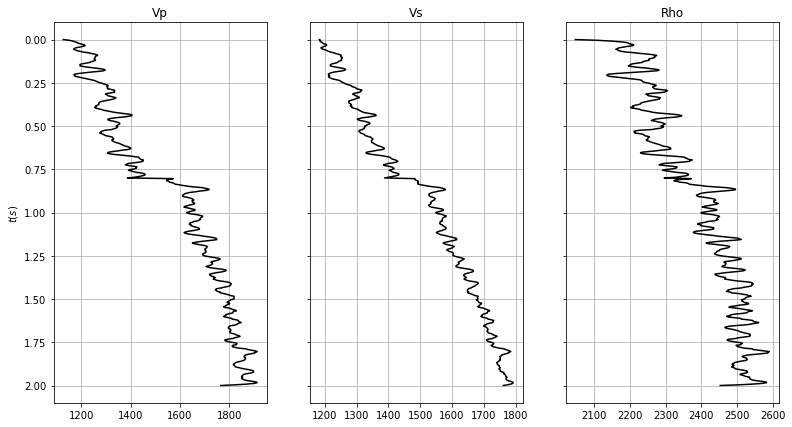

In [23]:
# Time and angles
nt0 = 501
dt0 = 0.004
ntheta = 21
thetamin, thetamax = 0, 50

t0 = np.arange(nt0)*dt0
theta = np.linspace(thetamin, thetamax, ntheta)

# Elastic property profiles
vp = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 80, nt0))
vs = 600 + np.arange(nt0)/2 + vp/2 + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 20, nt0))
rho = 1000 - np.arange(nt0)/2 + vp + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 30, nt0))
vp[201:] += 200
vs[201:] += 100
rho[201:] += 100

# Wavelet (both zero-phase and with delay)
ntwav = 101
wavoff = 10
wav, twav, wavc = ricker(t0[:ntwav//2+1], 5)
wav_phase = np.hstack((wav[wavoff:], np.zeros(wavoff)))

fig, axs = plt.subplots(1, 3, figsize=(13, 7), sharey=True)
axs[0].plot(vp, t0, 'k')
axs[0].set_title('Vp')
axs[0].set_ylabel(r'$t(s)$')
axs[0].invert_yaxis()
axs[0].grid()
axs[1].plot(vs, t0, 'k')
axs[1].set_title('Vs')
axs[1].invert_yaxis()
axs[1].grid()
axs[2].plot(rho, t0, 'k')
axs[2].set_title('Rho')
axs[2].invert_yaxis()
axs[2].grid()

At this point we combine the three well logs into a unique vector $\mathbf{m}$

In [24]:
# vs/vp profile
vsvp = 0.5
vsvp_z = np.linspace(0.4, 0.6, nt0)

# Model
m = np.stack((np.log(vp), np.log(vs), np.log(rho)), axis=1)

We can now create the operators to model a synthetic pre-stack seismic gather with a zero-phase wavelet.



In [25]:
Wavesop = \
    pylops.avo.prestack.PrestackWaveletModelling(m, theta, nwav=ntwav, wavc=wavc,
                                                 vsvp=vsvp, linearization='akirich')

We then apply those operators to the elastic model and create our synthetic seismic pre-stack data


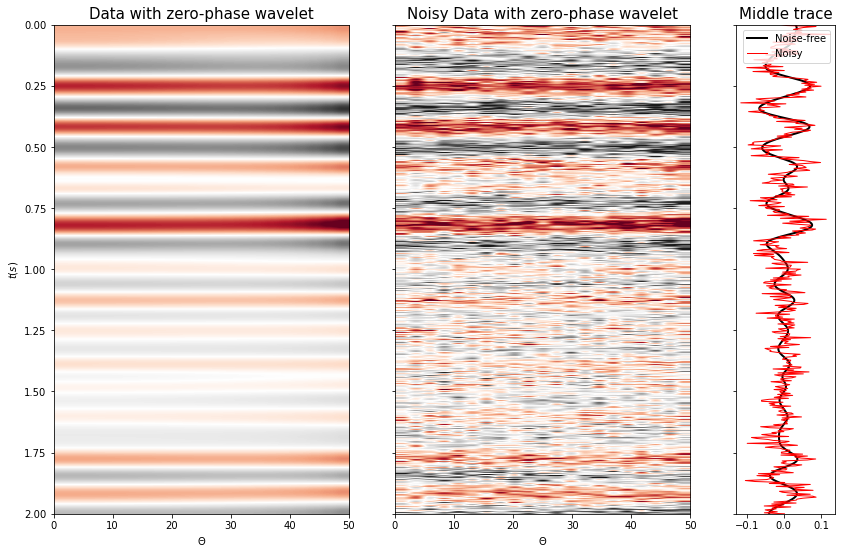

In [26]:
# Data
d = (Wavesop * wav).reshape(ntheta, nt0).T

# Add noise
dn = d + np.random.normal(0, 3e-2, d.shape)

fig, axs = plt.subplots(1, 3, figsize=(14, 9), sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0].imshow(d, cmap='RdGy_r', extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$')
axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data with zero-phase wavelet', fontsize=15)
axs[1].imshow(dn, cmap='RdGy_r', extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Noisy Data with zero-phase wavelet', fontsize=15)
axs[1].set_xlabel(r'$\Theta$');
axs[1].axis('tight')
axs[2].plot(d[:, ntheta//2], t0, 'k', lw=2, label='Noise-free')
axs[2].plot(dn[:, ntheta//2], t0, 'r', lw=1, label='Noisy')
axs[2].set_title('Middle trace', fontsize=15)
axs[2].legend();

We are finally ready invert the data and make an estimate of our wavelet. First we will consider noise-free data (inverse crime).

Subsequently we use the data to which we have added some random noise. Here, we need to add a [**regularization**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.RegularizedInversion.html) term in the inversion process to obtain a well-behaved wavelet also under noise conditions.

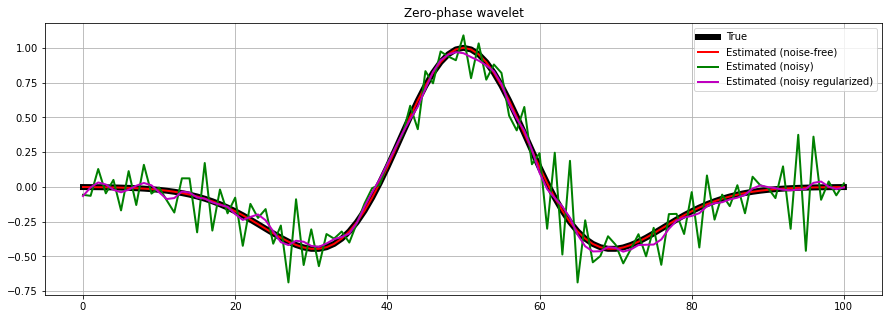

In [27]:
wav_est = Wavesop / d.T.flatten()
wavn_est = Wavesop / dn.T.flatten()

# Create regularization operator
D2op = pylops.SecondDerivative(ntwav)

# Invert for wavelet
wavn_reg_est, istop, itn, r1norm, r2norm = \
    pylops.optimization.leastsquares.RegularizedInversion(Wavesop, [D2op], dn.T.flatten(),
                                                          epsRs=[np.sqrt(0.1)], returninfo=True,
                                                          **dict(damp=np.sqrt(1e-4),
                                                                 iter_lim=200, show=0))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(wav_est, 'r', lw=2, label='Estimated (noise-free)')
ax.plot(wavn_est, 'g', lw=2, label='Estimated (noisy)')
ax.plot(wavn_reg_est, 'm', lw=2, label='Estimated (noisy regularized)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right')
ax.axis('tight');

Finally we repeat the same exercise, but this time we use a [**preconditioner**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.PreconditionedInversion.html).

Initially, our preconditioner is a `pylops.Symmetrize` operator to ensure that our estimated wavelet is zero-phase. After we chain the `pylops.Symmetrize` and the `pylops.Smoothing1D` operators to also guarantee a smooth wavelet.

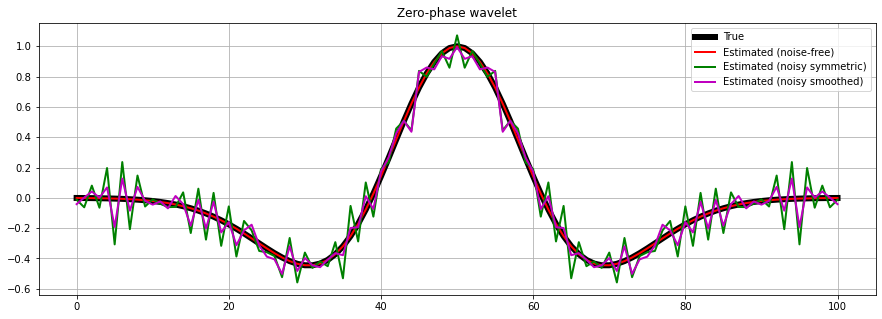

In [28]:
# Create symmetrize operator
Sop = pylops.Symmetrize((ntwav+1)//2)

# Create smoothing operator
Smop = pylops.Smoothing1D(11, dims=((ntwav+1)//2,))

# Invert for wavelet
wavn_prec_est = \
    pylops.optimization.leastsquares.PreconditionedInversion(Wavesop, Sop,
                                                             dn.T.flatten(),
                                                             returninfo=False,
                                                             **dict(damp=np.sqrt(1e-4),
                                                                    iter_lim=200,
                                                                    show=0))

wavn_smooth_est = \
    pylops.optimization.leastsquares.PreconditionedInversion(Wavesop, Sop * Smop,
                                                             dn.T.flatten(),
                                                             returninfo=False,
                                                             **dict(damp=np.sqrt(1e-4),
                                                                    iter_lim=200,
                                                                    show=0))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(wav_est, 'r', lw=2, label='Estimated (noise-free)')
ax.plot(wavn_prec_est, 'g', lw=2, label='Estimated (noisy symmetric)')
ax.plot(wavn_smooth_est, 'm', lw=2, label='Estimated (noisy smoothed)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right');

## Recap

In this first tutorial we have learned to:

- translate a linear operator from pen and paper to computer code
- write our own linear operators
- use PyLops linear operators to perform forward, adjoint and inverse
- combine PyLops linear operators.
- solve regularized and preconditioned inverse problems with PyLops optimization routines.

In [29]:
scooby.Report(core='pylops')

--------------------------------------------------------------------------------
  Date: Mon Apr 19 16:40:01 2021 +03

                OS : Darwin
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.5 (default, Sep  4 2020, 02:22:02)  [Clang 10.0.0 ]

            pylops : 1.12.1.dev37+g28a66cc.d20210326
             numpy : 1.19.2
             scipy : 1.5.2
           IPython : 7.19.0
        matplotlib : 3.3.2
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------